## Validating MCMC model

In this notebook, we look into way to validate model (MCMC) using [Posterior Predictive Checks \(PPC\)](https://docs.pymc.io/notebooks/posterior_predictive.html#Posterior-Predictive-Checks)

From documentation of the PPC of pymc3 (_link above_):
> *Elaborating slightly, one can say that PPCs analyze the degree to which data generated from the model deviate from data generated from the true distribution. So often you will want to know if, for example, your posterior distribution is approximating your underlying distribution. The visualization aspect of this model evaluation method is also great for a ‘sense check’ or explaining your model to others and getting criticism.*

In [1]:
import numpy as np
import pandas as pd
import AgentClass
import const
import random
import networkx as nx
from config import num_agents,number_of_bits
from scipy import stats
from collections import defaultdict
import json
import utilities

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib
import seaborn as sns

import pymc3 as pm


In [2]:
sns.set(style='darkgrid', rc={'figure.figsize':(10,6)}, font_scale=1.25)


In [3]:
def get_tau_distr():
    lower = 0
    upper = 1
    mu = 0.5
    sigma = 0.1
    N = 1000

    samples = stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)

    return samples

In [4]:
def create_environment():
    list_agents = []
    tau_distr = get_tau_distr()

    for i in range(num_agents):
        in_state = np.random.randint(2, size=number_of_bits).tolist()
        a = AgentClass.Agent(name='agent{}'.format(i), tau=random.choice(tau_distr), initial_state=in_state)
        list_agents.append(a)

    # create network
    G = nx.newman_watts_strogatz_graph(num_agents, 5, 0.5, seed= 0)
#    nx.draw(G, with_labels=True, font_weight='bold') # to draw agents
    df = nx.to_pandas_adjacency(G, dtype=int)

    tmp_edges = df.apply(lambda row: row.to_numpy().nonzero()).to_dict()
    edges = {k: v[0].tolist() for k, v in tmp_edges.items()}

    # make random connections with agents
    for k, v in edges.items():
        for ngh in v:
            list_agents[k].add_neighbors(list_agents[ngh])

    return list_agents

In [5]:
def get_network_df(list_agents):
    network_df = pd.DataFrame({'Agent Name':[], 'Neighbors':[]})
    for agt in list_agents:
        neighbors = agt.get_neighbors_name()
        network_df = network_df.append({'Agent Name':agt.name,
                                        'Neighbors':neighbors}, ignore_index=True)
    return network_df

In [6]:
def run_simulation(alpha, const:const.Constants, list_agents, end_time):
    d = []
    generations = 0
    for t in range(end_time):
        # compute next state for all agents
        for agt in list_agents:
            agt.update_knowledge(alpha, const.coh_transition_matrix, const.bit_matrix)

        # keep record of current record and all other values
        for agt in list_agents:
            row = {'Agent_Name':agt.name,
                   'Agent_Dissonance':np.array(agt.dissonance_lst),
                   'Time':t,
                   'probs':agt.soc_probs,
                   'Current_Knowledge_State':agt.knowledge_state,
                   'Current': utilities.bool2int(agt.knowledge_state),
                   'Next': utilities.bool2int(agt.next_state),
                   'Next_Knowledge_State':agt.next_state}

            d.append(row)

        # now update all agents next state with computed next state
        for agt in list_agents:
            agt.knowledge_state = agt.next_state
            agt.next_state = None
            agt.dissonance_lst = None

        generations+=1
#         if generations%10 == 0:
#             print("alpha = {}; {} generations".format(alpha,generations))

    return pd.DataFrame(d)

## Running simulation for generating data
> alpha = 0.1 <br>
> number of agents were set to 100 in config file <br>
> experiment time is only 1 currently, we may want to check with different random seed <br>
> coherence matrix is created with alpha_d value set to **alpha_d $\rightarrow$ .01** this will effect results coherence matrix <br>
> each agent moves for 100 steps starting from t=0 $\rightarrow$ t=99

In [7]:
 # constants intialization
end_simulation_time = 100
alphas = [0.1] 
exp_times = 1

# first create environment
agents_list = create_environment()

# get network of the agents
agent_network_df = get_network_df(agents_list)

# for saving the network of agents
# agent_network_df.to_json('test_network.json',orient='records', lines=True)

for i in range(exp_times):

    random.seed(i) # if later when we want to run with multiple random seed value
    constants = const.Constants()
    # generating coherence matrix
    coherence_matrix = constants.get_coh_tx_matrix().tolist()

    # run simulation
    for alpha in alphas:

        record_df = run_simulation(alpha, constants, agents_list, end_simulation_time)

Viewing how coherence matrix that generated data:

In [8]:
display(pd.DataFrame(coherence_matrix))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.000000,0.000000,0.000000,0.176531,0.000000,0.000000,0.0,0.000000,0.0,0.823469,0.000000,0.000,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.492279,0.507721,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.000,0.000000,0.0,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.000000
5,0.000000,0.986961,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.013039,0.000,0.000000,0.0,0.000000
6,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.000000
7,0.178325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000,0.001594,0.0,0.820081
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.387650,0.000000,0.0,0.008982,0.0,0.000000,0.000000,0.000,0.603368,0.0,0.000000
9,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.000000


Once we have run the simulation, we have results in "record_df".
We can look at distribution of state transitions as below: 

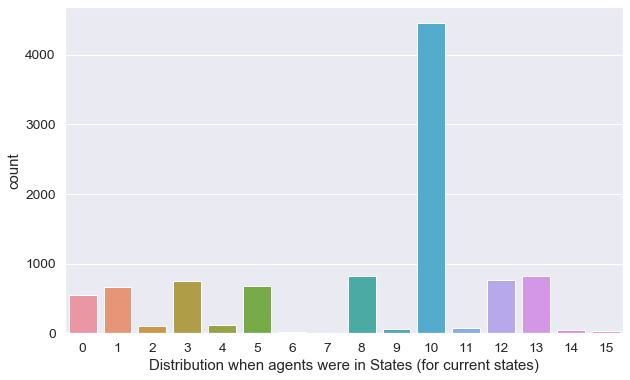

In [9]:
sns.countplot(x='Current', data=record_df);
plt.xlabel('Distribution when agents were in States (for current states)');

We will select one of the state above for checking distributions and MCMC modeling.
> stored in *'sel_state'* variable below

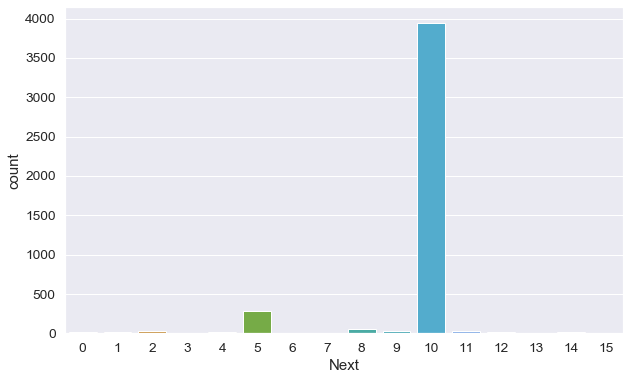

In [10]:
sel_state = 10

data = record_df[record_df['Current']==sel_state]
sns.countplot(x='Next', data=data)

In [ ]:
import arviz as az

# Using pyMC3

Using pymc3 MCMC sampling to estimate parameters, for now we only estimate probability of state transitions given a selected state

In [12]:
soc_probs = np.asarray(data['probs'].tolist()) # for now using final result of soc_probs this has to change to handle "tau" of agents
y = np.asarray(data['Next'].tolist()) # this is the next state values for each data from simulations
k = 2**number_of_bits # this is number of possible states 
#Try 1-hot encoding
y_hot = np.eye(k)[y] # we changed above state values to one hot encoding

alpha = alphas[0] # for now not estimating alpha values, instead using same as used in generation of data

Running MCMC with default No-U-Turn Sampler 
> For details: [The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo](https://arxiv.org/pdf/1111.4246.pdf)

In [13]:
with pm.Model() as model:
    
    # initializes the Dirichlet distribution with a uniform prior:
    a = np.ones(k) 
    
    theta = pm.Dirichlet("theta", a=a, shape=k)
    tmp = alpha*soc_probs + (1-alpha)*theta
       
    results = pm.Multinomial("results", n=1, p=tmp, observed=y_hot, shape=k)

C:\Users\niraj\AppData\Local\Continuum\anaconda3\envs\probabilistic\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


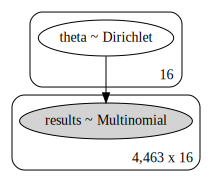

In [14]:
pm.model_to_graphviz(model)

pm.sample from pymc3 draws samples from the posterior using the given step methods.
> For details on parameters [pymc3 reference](https://docs.pymc.io/api/inference.html)

In [15]:
with model:
     trace = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 8000/8000 [01:19<00:00, 100.32draws/s]


In [16]:
from IPython.display import display_html

In [18]:
def display_side_by_side(*args):
    """This function is only for viewing two dataframe side by side
    It helps to compare how the distributions are in original and sampled traces for now
    Reference: https://stackoverflow.com/a/44923103/5916727"""
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

Comparing side by side how well did MCMC did with mean values of samples from trace of MCMC

In [19]:
trace_df = pm.summary(trace).round(4)[['mean']]
trace_df.columns = ['trace Mean']
coh_df = pd.DataFrame(pd.DataFrame(coherence_matrix).iloc[sel_state])
coh_df.columns = ['Coh_matrix Mean']

C:\Users\niraj\AppData\Local\Continuum\anaconda3\envs\probabilistic\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


In [20]:
display_side_by_side(coh_df, trace_df)

,Coh_matrix Mean
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.064546
6,0.000000
7,0.000000
8,0.000000
9,0.000000


## Using Post Predictive Check

Below function will randomly draw 500 samples of parameters from the trace. Then, for each sample, it will draw 4,463 random numbers from a normal distribution specified by the values of mu and std in that sample. 
> [pymc3 documentation reference](https://docs.pymc.io/notebooks/posterior_predictive.html)

Then, we will look into visualization if model can reproduce the patterns observed in the real data. For example, how close are the inferred means to the actual sample mean. In our case we will compare how close the model is with mean from coherence matrix for that selected state

In [21]:
ppc = pm.sample_posterior_predictive(trace, samples=500, model=model)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 85.11it/s]


In [22]:
np.asarray(ppc['results']).shape

(500, 4463, 16)

In our original coherence matrix, for the given state we only have two non-zero values, others were zero. Below we can view how far the distribution deviates from the original mean from coherence matrix.

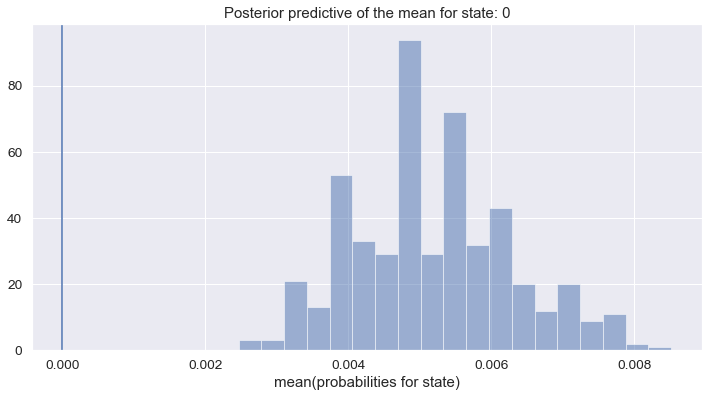

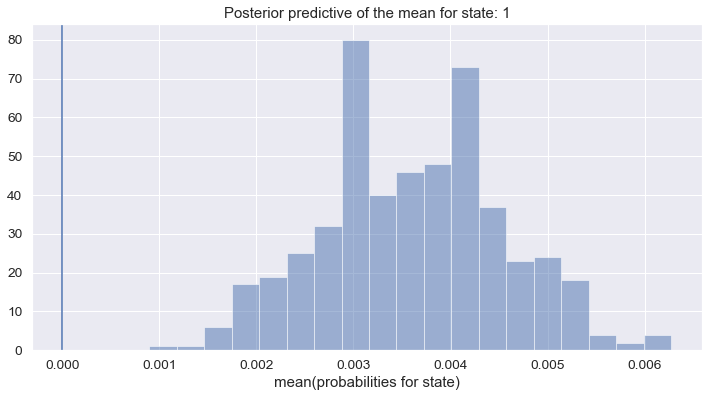

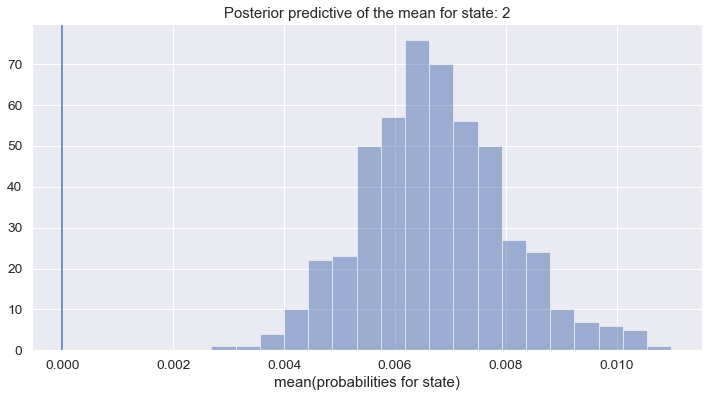

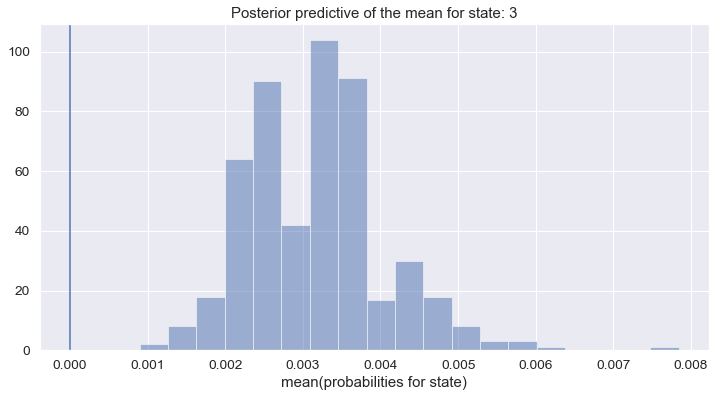

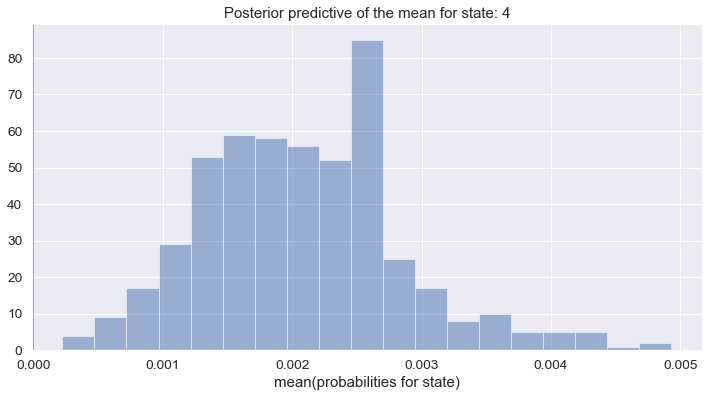

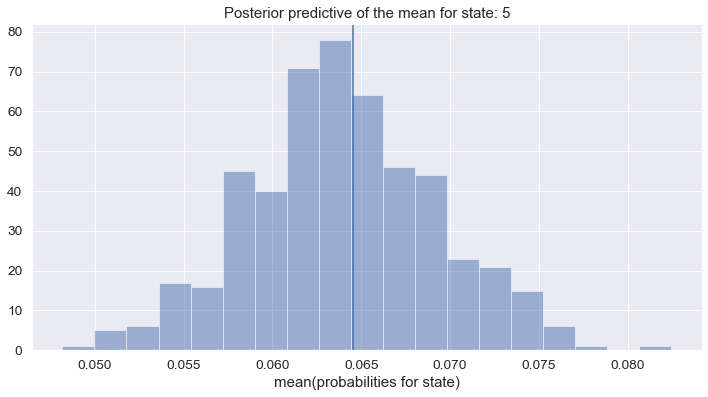

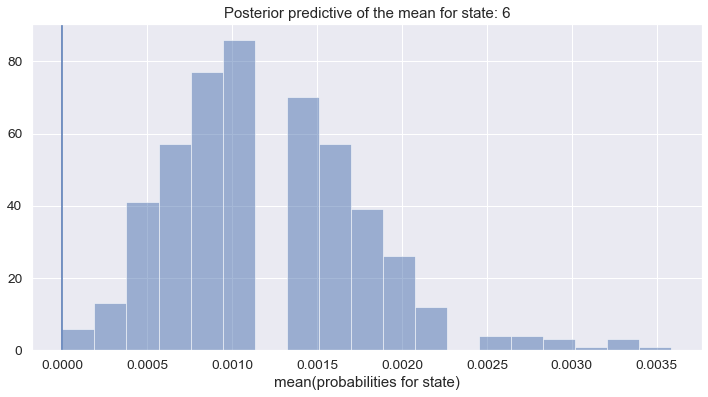

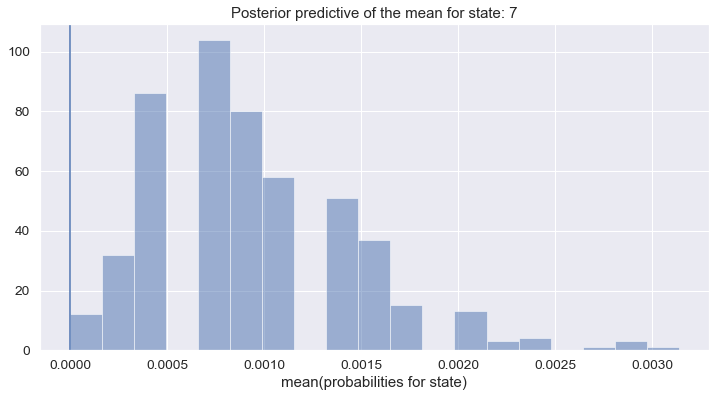

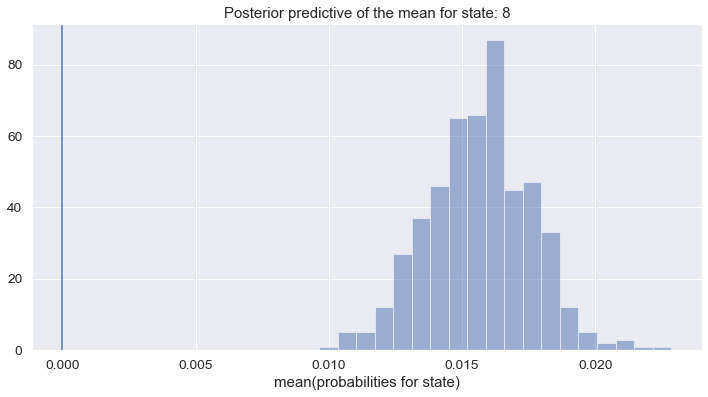

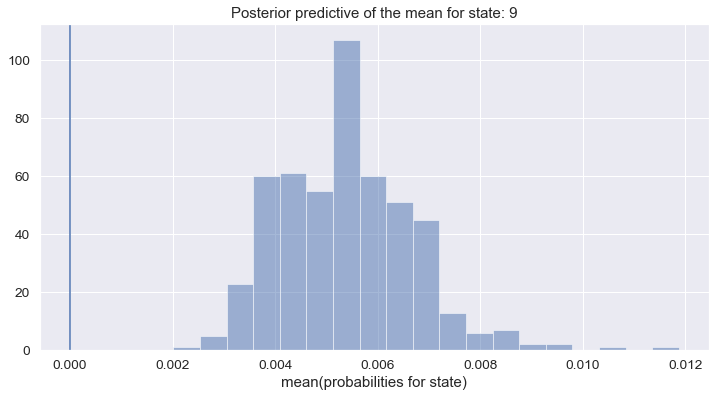

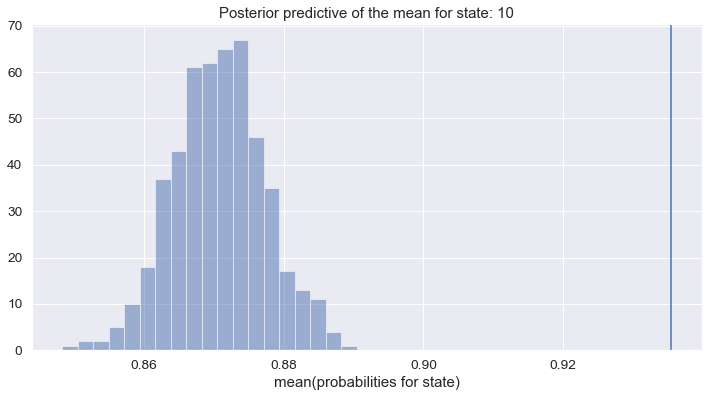

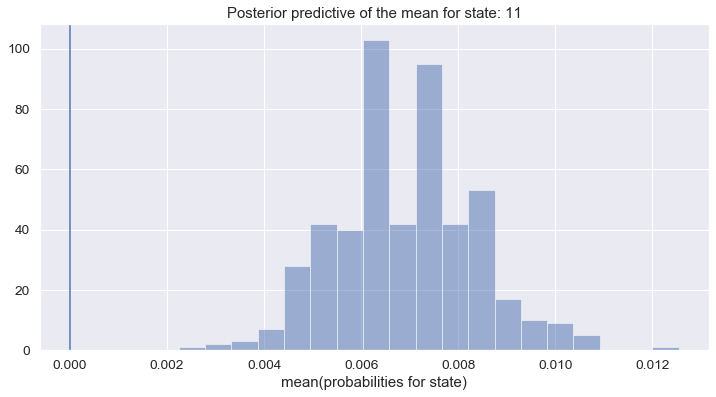

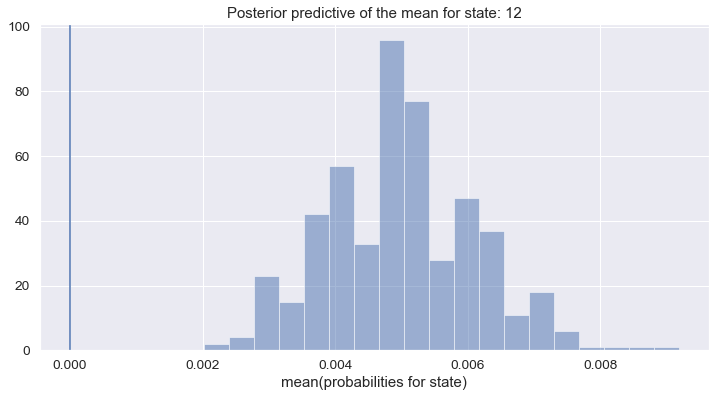

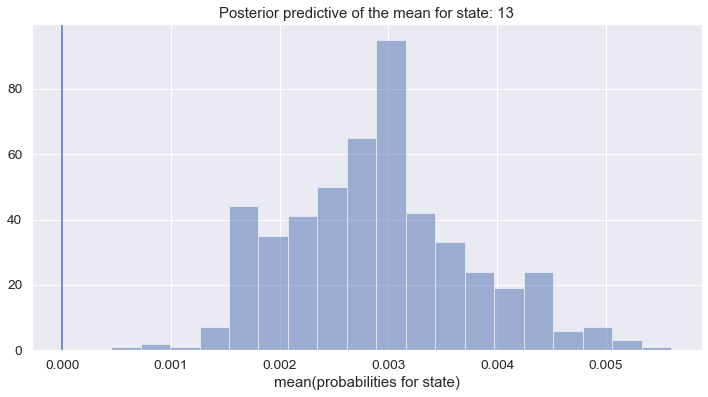

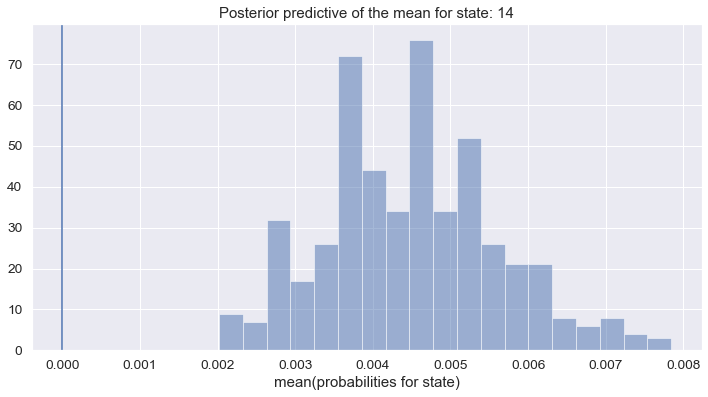

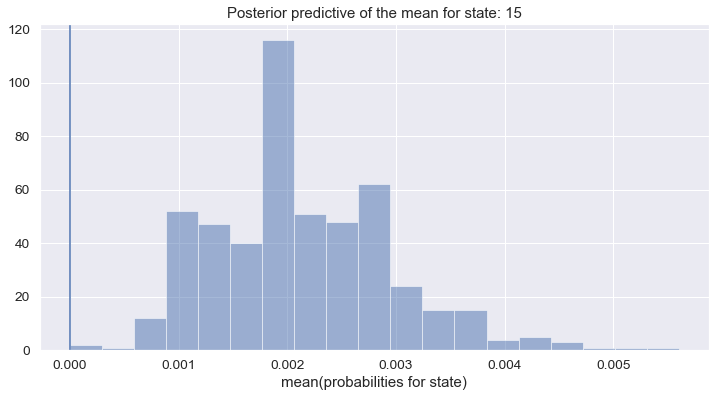

In [23]:
for i in range(16):
    tmp = ppc['results'][:, :, i]
    _, ax = plt.subplots(figsize=(12, 6))
    ax.hist([n.mean() for n in tmp], bins=19, alpha=0.5)
    ax.axvline(coh_df.iloc[i].values[0])
    
    ax.set(title='Posterior predictive of the mean for state: {}'.format(i), xlabel='mean(probabilities for state)');

In [25]:
ppc_df = pd.DataFrame(ppc['results'].mean(axis=0).mean(axis=0))
ppc_df.columns = ['Sampled mean']

In [26]:
display_side_by_side(coh_df, trace_df, ppc_df)

,Coh_matrix Mean
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.064546
6,0.000000
7,0.000000
8,0.000000
9,0.000000
